In [ ]:
# @title Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# @title Install Dependencies
!pip install --upgrade tensorflow
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling 

In [ ]:
# @title Dataset: Import & Extract (from Google Drive)
# @markdown Dataset Path:
DATASET = "/content/drive/MyDrive/Dataset.zip"  # @param {type:"string"}
!mkdir -p /content
!unzip -d /content -B {DATASET}

Streaming output truncated to the last 5000 lines.
  inflating: /content/Validation/Real/real_5499.jpg  
  inflating: /content/Validation/Real/real_55.jpg  
  inflating: /content/Validation/Real/real_550.jpg  
  inflating: /content/Validation/Real/real_5500.jpg  
  inflating: /content/Validation/Real/real_5501.jpg  
  inflating: /content/Validation/Real/real_5502.jpg  
  inflating: /content/Validation/Real/real_5503.jpg  
  inflating: /content/Validation/Real/real_5504.jpg  
  inflating: /content/Validation/Real/real_5505.jpg  
  inflating: /content/Validation/Real/real_5506.jpg  
  inflating: /content/Validation/Real/real_5507.jpg  
  inflating: /content/Validation/Real/real_5508.jpg  
  inflating: /content/Validation/Real/real_5509.jpg  
  inflating: /content/Validation/Real/real_551.jpg  
  inflating: /content/Validation/Real/real_5510.jpg  
  inflating: /content/Validation/Real/real_5511.jpg  
  inflating: /content/Validation/Real/real_5512.jpg  
  inflating: /content/Validation/Re

In [ ]:
# @title Verify Dataset
# @markdown Dataset Path
import os
data_dir = "/content/Dataset" # @param {type:"string"}
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")
validation_dir = os.path.join(data_dir, "Validation")
subfolders = ["Fake", "Real"]

def setup_directory_and_count_files(directory, subfolders):
    total_files = 0
    for subfolder in subfolders:
        subfolder_path = os.path.join(directory, subfolder)
        total_files += sum([1 for file in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, file))])
    return total_files

total_train_files = setup_directory_and_count_files(train_dir, subfolders)
total_test_files = setup_directory_and_count_files(test_dir, subfolders)
total_validation_files = setup_directory_and_count_files(validation_dir, subfolders)

total = total_train_files + total_test_files + total_validation_files
train_perc = (total_train_files / total) * 100
test_perc = (total_test_files / total) * 100
valid_perc = (total_validation_files / total) * 100
print("Total Train Files:", total_train_files)
print("Total Test Files:", total_test_files)
print("Total Validation Files:", total_validation_files)
print(f"Train Data Percentage: {train_perc:.2f}%")
print(f"Test Data Percentage: {test_perc:.2f}%")
print(f"Validation Data Percentage: {valid_perc:.2f}%")

Total Train Files: 140002
Total Test Files: 10905
Total Validation Files: 39428
Train Data Percentage: 73.56%
Test Data Percentage: 5.73%
Validation Data Percentage: 20.72%


In [ ]:
# @title Model Training
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

# @markdown Epochs
epoch_num = 50 # @param {type:"slider", min:0, max:75, step:1}

def normalize_image(image, labels):
    image = tf.cast(image, tf.float32) / 255.0
    return image, labels

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
).map(normalize_image).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
).map(normalize_image).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
).map(normalize_image).prefetch(buffer_size=tf.data.AUTOTUNE)

model_CNN = Sequential([
    Conv2D(filters=8, kernel_size=3, padding='same', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=16, kernel_size=4, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),

    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),

    Conv2D(filters=128, kernel_size=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    Flatten(),
    tf.keras.layers.Dropout(0.3),
    Dense(units=64, activation='relu'),
    Dense(units=20, activation='relu'),
    Dense(units=2, activation='softmax')
])

model_CNN.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = 'BinaryCrossentropy',
                metrics=['accuracy'])

hist = model_CNN.fit(train_data,
                    epochs = epoch_num,
                    validation_data = validation_data,
                    validation_steps = int(0.5 * len(validation_data))
                    )

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

# Define the path to your Google Drive folder where you want to save the checkpoints.
# Replace 'your_folder' with your desired folder path.
drive_folder_path = '/content/drive/MyDrive/models2'
# Create the directory if it doesn't exist
os.makedirs(drive_folder_path, exist_ok=True)

# Define a function to normalize the image data
def normalize_image(image, labels):
    image = tf.cast(image, tf.float32) / 255.0
    return image, labels

# Define dataset directories (replace with your dataset paths)
train_dir = '/content/Train/'
validation_dir = '/content/Validation/'
test_dir = '/content/Test/'

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

# Create data generators
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
).map(normalize_image).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
).map(normalize_image).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
).map(normalize_image).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the CNN model
model_CNN = tf.keras.Sequential([
    Conv2D(filters=8, kernel_size=3, padding='same', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=16, kernel_size=4, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),

    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),

    Conv2D(filters=128, kernel_size=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    Flatten(),
    tf.keras.layers.Dropout(0.3),
    Dense(units=64, activation='relu'),
    Dense(units=20, activation='relu'),
    Dense(units=2, activation='softmax')
])

# Compile the model
model_CNN.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='BinaryCrossentropy',
    metrics=['accuracy']
)

# Define a custom callback to print a message when a checkpoint is saved
class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        print(f"Checkpoint saved at epoch
        {epoch + 1}")

# Define a checkpoint callback
# @markdown Epochs:
epoch_num = 50  # @param {type:"slider", min:0, max:75, step:1}
# @markdown Model Save Frequency:
savefq = 10 # @param {type:"slider", min:2, max:15, step:1}

checkpoint_callback = CustomModelCheckpoint(
    filepath=os.path.join(drive_folder_path, 'model_checkpoint_{epoch:02d}.h5'),
    save_best_only=False,
    save_weights_only=False,
    save_freq = savefq,
    verbose=1
)

# Train the model with checkpoint callback

hist = model_CNN.fit(
    train_data,
    epochs=epoch_num,
    validation_data=validation_data,
    validation_steps=int(0.5 * len(validation_data)),
    callbacks=[checkpoint_callback]
)

# Save the final model to Google Drive
final_model_path = os.path.join(drive_folder_path, 'final_model.h5')
model_CNN.save(final_model_path)

# Print a message to indicate completion
print("Model training and checkpoint saving completed.")


Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Epoch 1/50


In [ ]:
# @title Save the Trained Model
svpth = '/content/drive/MyDrive/'
# @markdown Save Model As:
model_name = "dfimgdet50ep" # @param {type:"string"}
modelwext = model_name + ".h"
save_path = svpth + modelwext
model_CNN.save(save_path)

In [1]:
# @title Load a Model
from tensorflow.keras.models import load_model
# @markdown Model Path:
model_path = '/content/deepfake.h5' # @param {type:"string"}
loaded_model = load_model(model_path)

In [4]:
# @title Upload an Image (Custom Input)
from google.colab import files
# Upload an image from your local machine
uploaded = files.upload()

from tensorflow.keras.preprocessing import image
import numpy as np

# Image pre-processing
uploaded_image_path = list(uploaded.keys())[0]
img = image.load_img(uploaded_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
predictions = loaded_model.predict(img_array)

# @markdown Threshold:
threshold = 0.5 # @param {type:"slider", min:0, max:1, step:0.1}
if predictions[0][0] >= threshold:
    print("The uploaded image is a deepfake.")
else:
    print("The uploaded image is not a deepfake.")

Saving real.jpg to real.jpg
1/1 [==============================] - 0s 19ms/step
The uploaded image is not a deepfake.


In [ ]:
!pip install opencv-python-headless matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# Replace 'your_model_path.h5' with the path to your saved model
model = load_model('/content/model_checkpoint_33.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 8)       0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 8)       32        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 128, 128, 8)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      2064      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 16)       

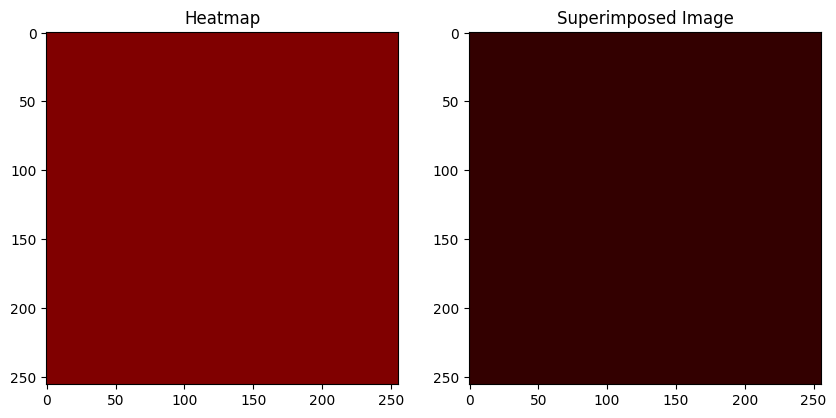

In [ ]:
#Trial

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# Load your trained model
model_path = '/content/model_checkpoint_33.h5'  # Replace with the path to your saved model
model_CNN = load_model(model_path)

# Load an example image (replace with your own image loading logic)
image_path = '/content/fake_16.jpg'  # Replace with the path to the image you want to analyze
image = cv2.imread(image_path)
image = cv2.resize(image, (256, 256))  # Resize the image to match the input size of your model
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Preprocess the image
image = image / 255.0  # Normalize the image
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Replace 'output_layer_name' with the name of the output layer in your model
output_layer_name = "dense_5"  # Name of the output layer from your model

# Create a model for feature extraction
feature_extraction_model = Model(inputs=model_CNN.input, outputs=model_CNN.get_layer(output_layer_name).output)

# Get the model's prediction
predictions = feature_extraction_model(image)

# Generate the heatmap
heatmap = predictions[0, 1]  # Assuming it's a binary classification model and you want the heatmap for the positive class
heatmap = tf.maximum(heatmap, 0)

# Normalize the heatmap
heatmap /= tf.reduce_max(heatmap)

# Convert the heatmap tensor to a NumPy array
heatmap = heatmap.numpy()

# Ensure that the heatmap is in the correct data type (float32)
heatmap = heatmap.astype(np.float32)

# Handle NaN or Inf values by setting them to zero
heatmap = np.nan_to_num(heatmap)

# Normalize the heatmap
heatmap_min = np.min(heatmap)
heatmap_max = np.max(heatmap)

if heatmap_max != heatmap_min:
    heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)  # Normalize the values between 0 and 1
else:
    heatmap = 0  # Avoid division by zero if the heatmap is constant

# Resize the heatmap to match the original image size using OpenCV
heatmap = cv2.resize(heatmap, (256, 256))

# Scale the heatmap values to the range [0, 255] for visualization
heatmap = (heatmap * 255).astype(np.uint8)

# Convert the image to the same data type as the heatmap
image = image.astype(np.uint8)

# Apply the heatmap as an overlay on the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(image[0], 0.6, heatmap, 0.4, 0)

# Display the heatmap and the superimposed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(heatmap)
plt.title('Heatmap')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Superimposed Image')
plt.show()


1/1 [==============================] - 0s 212ms/step


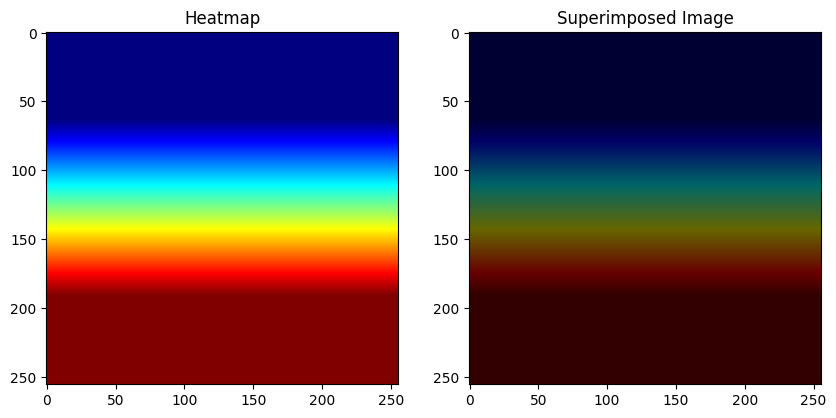

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# Load your deepfake detection model
model_path = '/content/model_checkpoint_33.h5'
model = load_model(model_path)

# Load an example image
image_path = '/content/fake_23.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (256, 256))  # Resize the image to match the input size of your deepfake detection model
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Preprocess the image
image = image / 255.0  # Normalize the image
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Make predictions using the deepfake detection model
predictions = model.predict(image)

# Assuming predictions contain the probability of deepfake (e.g., class 1), you can create a heatmap
# based on these probabilities to highlight deepfake areas

# Create a heatmap based on the probability of deepfake
heatmap = predictions[0]  # Assuming it's a binary classification model, and you want class 1 (deepfake) probability
heatmap = tf.maximum(heatmap, 0)  # Ensure all values are positive

# Normalize the heatmap
heatmap /= tf.reduce_max(heatmap)

# Convert the heatmap tensor to a NumPy array
heatmap = heatmap.numpy()

# Ensure that the heatmap is in the correct data type (float32)
heatmap = heatmap.astype(np.float32)

# Handle NaN or Inf values by setting them to zero
heatmap = np.nan_to_num(heatmap)

# Normalize the heatmap
heatmap_min = np.min(heatmap)
heatmap_max = np.max(heatmap)

if heatmap_max != heatmap_min:
    heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)  # Normalize the values between 0 and 1
else:
    heatmap = 0  # Avoid division by zero if the heatmap is constant

# Resize the heatmap to match the original image size using OpenCV
heatmap = cv2.resize(heatmap, (256, 256))

# Scale the heatmap values to the range [0, 255] for visualization
heatmap = (heatmap * 255).astype(np.uint8)

# Convert the image to the same data type as the heatmap
image = image.astype(np.uint8)

# Apply the heatmap as an overlay on the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(image[0], 0.6, heatmap, 0.4, 0)

# Display the heatmap and the superimposed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(heatmap)
plt.title('Heatmap')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Superimposed Image')
plt.show()


1/1 [==============================] - 0s 148ms/step


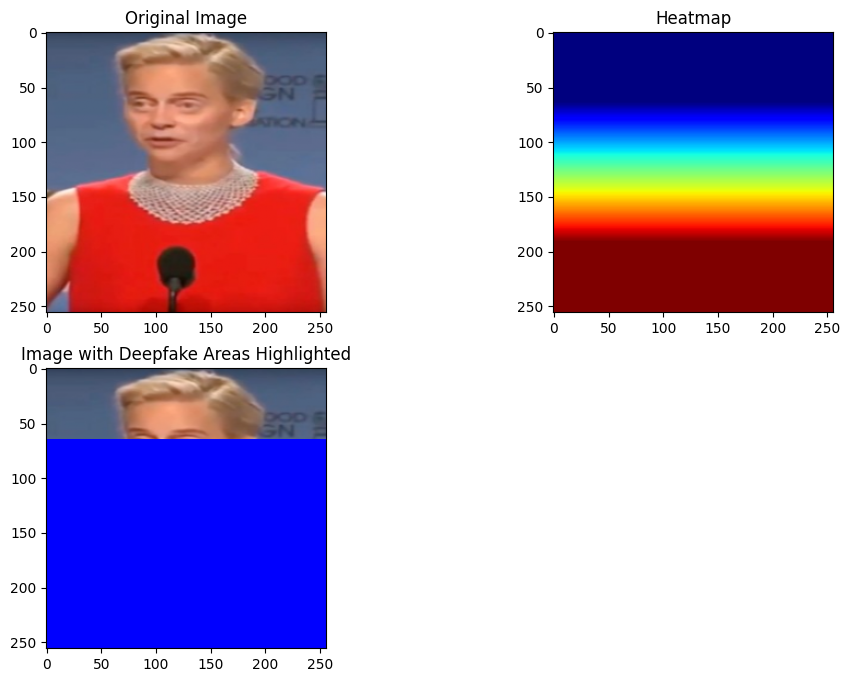

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model

# Load your deepfake detection model
model_path = '/content/model_checkpoint_32.h5'
model = load_model(model_path)

# Load an example image
image_path = '/content/original2.jpg'
image = cv2.imread(image_path)
image = cv2.resize(image, (256, 256))  # Resize the image to match the input size of your deepfake detection model
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Preprocess the image
image = image / 255.0  # Normalize the image
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Make predictions using the deepfake detection model
predictions = model.predict(image)

# Assuming predictions contain the probability of deepfake (e.g., class 1), you can create a heatmap
# based on these probabilities to highlight deepfake areas

# Create a heatmap based on the probability of deepfake
heatmap = predictions[0]  # Assuming it's a binary classification model, and you want class 1 (deepfake) probability
heatmap = tf.maximum(heatmap, 0)  # Ensure all values are positive

# Normalize the heatmap
heatmap /= tf.reduce_max(heatmap)

# Convert the heatmap tensor to a NumPy array
heatmap = heatmap.numpy()

# Ensure that the heatmap is in the correct data type (float32)
heatmap = heatmap.astype(np.float32)

# Handle NaN or Inf values by setting them to zero
heatmap = np.nan_to_num(heatmap)

# Normalize the heatmap
heatmap_min = np.min(heatmap)
heatmap_max = np.max(heatmap)

if heatmap_max != heatmap_min:
    heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)  # Normalize the values between 0 and 1
else:
    heatmap = 0  # Avoid division by zero if the heatmap is constant

# Resize the heatmap to match the original image size using OpenCV
heatmap = cv2.resize(heatmap, (256, 256))

# Scale the heatmap values to the range [0, 255] for visualization
heatmap = (heatmap * 255).astype(np.uint8)

# Create a mask based on the heatmap
threshold = 0.5  # Adjust the threshold as needed
mask = (heatmap > threshold).astype(np.uint8)

# Convert the mask to a three-channel image with red color for highlighting
highlight_color = [0, 0, 255]  # Red color
highlighted_image = image[0].copy()
highlighted_image[mask == 1] = highlight_color  # Set deepfake areas to red

# Display the original image, heatmap, and the image with deepfake areas highlighted
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(image[0])
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.title('Heatmap')

plt.subplot(2, 2, 3)
plt.imshow(highlighted_image)
plt.title('Image with Deepfake Areas Highlighted')

plt.show()
